# FCR in Dimensions

The goal of this notebook is to analyze
the FCR index data of a single journal
based on the CSV reports
from [Dimensions](https://app.dimensions.ai).
We can get at most $500$ entries from its search system,
which suffices in our case
without an extra step of search splitting and CSV joining
(sadly, we couldn't download the full data from some journals
 due to that limit on the number of rows
 and due to the constrained ways os manually splitting the data
 in the interface).

*Note*: Be careful when downloading stuff from a single journal!
As the Dimensions' web interface uses the journal name for filtering
instead of its ISSN,
sometimes we can grab a CSV from more than one journal
because they happen to have the same name.
As an example, *Topoi* can be either a
[Brazilian journal of history](http://revistatopoi.org)
and a
[Dutch journal of philosophy](https://link.springer.com/journal/11245),
but these journals are mixed together in that interface.

There are two CSV formats available:
a spreadsheet and a bibliometric mapping.
Their first line in both formats is always
a comment with some metadata regarding the downloaded CSV,
including the date.
The second line is the table header.

In [1]:
import csv

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [3]:
%matplotlib inline

## Analyzing the FCR from the spreadsheet file

There are $2$ bibliometric indices: `RCR` and `FCR`.
The former is probably useless
for anything that isn't a health science publication
regarding the research going on in the U.S.A.,
since its calculation
[is based on the number of citations from publications funded by the
 NIH](https://support.dimensions.ai/support/solutions/articles/13000045404-what-is-the-rcr-how-is-the-rcr-score-calculated-)
(*National Institutes of Health* in the U.S.A.).
The latter is the *Field Citation Ratio*,
[which is somehow normalized by both year and Field of
 Research](https://support.dimensions.ai/support/solutions/articles/13000045409-what-is-the-fcr-how-is-it-calculated-),
and is the only one we're going to analyze here.

### Loading the data

We should be explicit about the header line
since the first line of the CSV files
is a comment:

In [4]:
with open("nauplius.csv") as f:
    cr = csv.reader(f)
    print(next(cr)[0])

About the data: Exported on Sep 21, 2018. Criteria: Source title is Nauplius.


We're going to analyze the content of this journal.

In [5]:
nauplius = pd.read_csv("nauplius.csv", header=1)
print(nauplius.shape)
nauplius.columns

(177, 27)


Index(['Rank', 'Publication ID', 'DOI', 'PMID', 'PMCID', 'Title',
       'Source title', 'Anthology title', 'PubYear', 'Volume', 'Issue',
       'Pagination', 'Publication Type', 'Authors', 'Authors Affiliations',
       'Times cited', 'Recent citations', 'RCR', 'FCR', 'Source Linkout',
       'Dimensions URL', 'FOR (ANZSRC) Categories', 'FOR 1', 'FOR 2', 'FOR 3',
       'FOR 4', 'FOR 5'],
      dtype='object')

We can see the number of publications by year:

,count
PubYear,
2011,19
2012,21
2013,22
2014,16
2015,18
2016,30
2017,33
2018,18


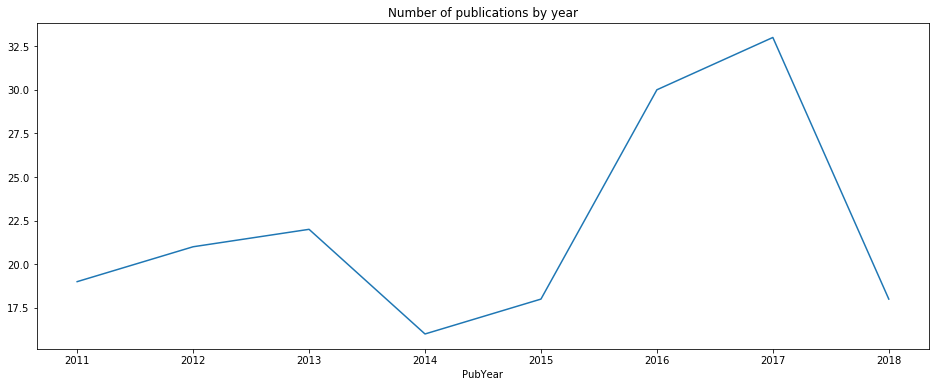

In [6]:
year_counts = nauplius.groupby("PubYear").size().rename("count")
year_counts.T.plot(title="Number of publications by year",
                   figsize=(16, 6))
pd.DataFrame(year_counts)

Which shows that *Nauplius* is a quite new and currently active journal.

### Proportion where the FCR is zero

From the [FCR
 explanation](https://support.dimensions.ai/support/solutions/articles/13000045409-what-is-the-fcr-how-is-it-calculated-)
page in the Dimensions support,
we know that:

> The FCR is calculated for all publications in Dimensions
> which are at least 2 years old and were published in 2000 or later.

FCR is zero when a document hadn't received any citation
or when it was published in the last $2$ years.
That's a quite common case, surely for new papers,
which deserves its own analysis.

True     91
False    86
Name: FCR, dtype: int64

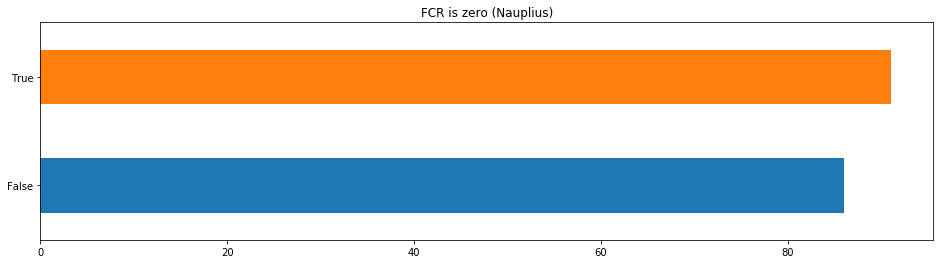

In [7]:
fcr_is_zero = (nauplius["FCR"] == 0).value_counts()
fcr_is_zero.sort_index().plot.barh(
    figsize=(16, 4),
    title="FCR is zero (Nauplius)"
)
fcr_is_zero

For a recent journal, more than half of the entries have zero as its FCR.
The FCR mean for this journal as a whole
would be tainted if we count these entries as equal.

Most entries with zeroed FCR values are for $2017$ and $2018$,
years where all entries are zero.

fcr_is_zero,False,True
PubYear,,
2011,17,2
2012,14,7
2013,18,4
2014,11,5
2015,12,6
2016,14,16
2017,0,33
2018,0,18


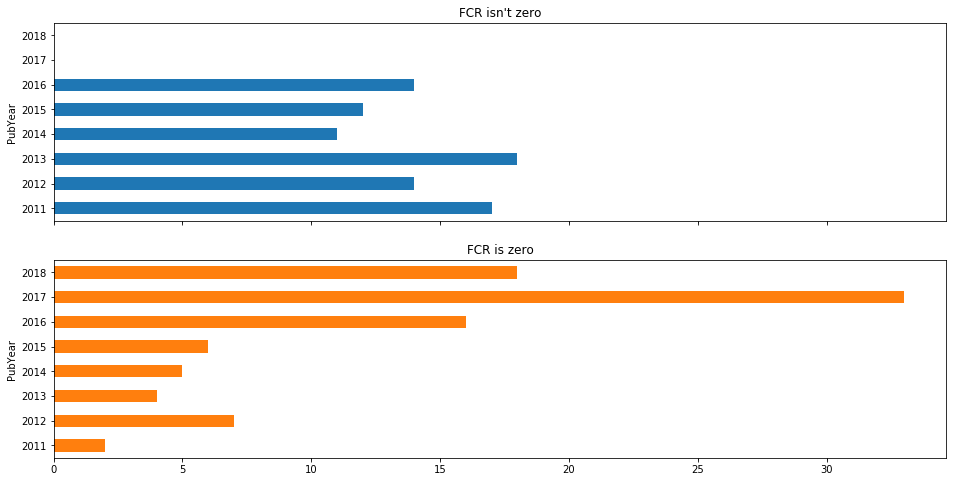

In [8]:
nauplius_counts = pd.DataFrame(
    nauplius
        .assign(fcr_is_zero=nauplius["FCR"] == 0)
        .groupby(["fcr_is_zero", "PubYear"])
        .size()
        .rename("count")
        .unstack("fcr_is_zero")
        .fillna(0),
    dtype=int,
)
nauplius_counts.plot.barh(subplots=True,
                          title=["FCR isn't zero",
                                 "FCR is zero"],
                          legend=False,
                          figsize=(16, 8))
nauplius_counts

As $2017$ was the publication peak for Nauplius,
averaging the raw FCR number for every year is unfair.

Another reason for these zeros is that the FCR can only be calculated
if we know the *Field of Research* of every single document.
However, from the same link as before,

> Assigning FoR codes to publications in Dimensions is done automatically using machine learning emulations of the categorisation processes.

The FCR can't be negative,
but when a document lacks its category,
the FCR is zero.

In [9]:
# Entries without any category
nauplius["FOR (ANZSRC) Categories"].isna().sum()

14

As $\text{FCR} \ge 0$ and $\sum \text{FCR}_i = 0$,
all these journals have $\text{FCR} = 0$.

In [10]:
nauplius[nauplius["FOR (ANZSRC) Categories"].isna()]["FCR"].sum()

0.0

The distribution of these zeros, by year:

In [11]:
nauplius[nauplius["FOR (ANZSRC) Categories"].isna()].groupby("PubYear").size()

PubYear
2011    1
2012    2
2013    3
2015    2
2016    2
2017    1
2018    3
dtype: int64

### Data cleaning

The cleaning we're sure that must be done
in order to have meaningful entries
for further analysis regarding the FCR
is that we should only use data up to $2016$
and get rid from entries without a main field of research.

In [12]:
nauplius_valid = nauplius[nauplius["FOR (ANZSRC) Categories"].notna() &
                          (nauplius["PubYear"] <= 2016)]

In the CSV file, everything is an article,
so we shouldn't remove any other row:

In [13]:
nauplius["Publication Type"].drop_duplicates()

0    article
Name: Publication Type, dtype: object

### Hirsch index

As the total number of citations each document received is given,
we can calculate the Hirsch index for this journal
based on the entire data.

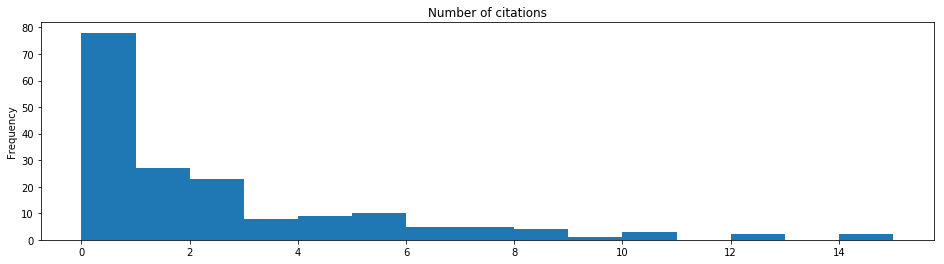

In [14]:
nauplius["Times cited"].plot.hist(
    bins=nauplius["Times cited"].max(),
    title="Number of citations",
    figsize=(16, 4),
);

The Hirsch index for Nauplius is:

In [15]:
(nauplius["Times cited"]
    .value_counts()
    .sort_index(ascending=False)
    .cumsum()
    .reset_index()
    .values.min(axis=1)
    .max()
)

8

The above is based on all citations since the publication,
which is something that might lean toward
journals with older publications.

### Proportion where FCR isn't zero

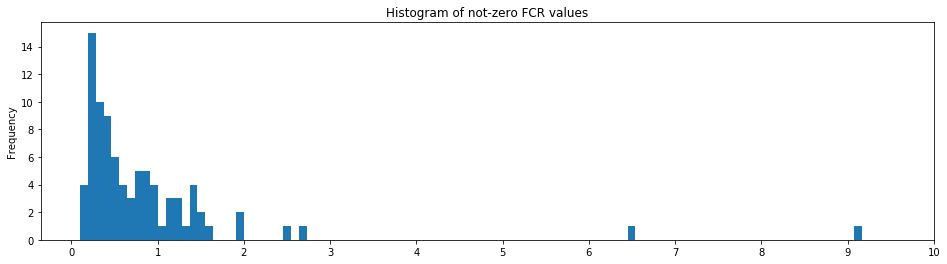

In [16]:
nauplius[nauplius["FCR"] != 0]["FCR"].plot.hist(
    bins=100,
    title="Histogram of not-zero FCR values",
    figsize=(16, 4),
    xticks=range(int(nauplius["FCR"].max()) + 2),
);

All FCR values above $1$ received more citations than the average
for the year of publication and for the field of research.
That normalization makes FCR more fit than the raw number of citations
when we're looking to summary data
without knowing when each publication had been made.

### Average

Dimensions tells us the average FCR for Nauplius is $0.49$.
That means that the number of citations it received is,
in average,
about half of the average number of citations
of its field of research area.
That's called *FCR Mean* in the Dimensions' web site.

The idea of *average* might be misleading here.
As the mean value is highly influenced by extreme values,
In the same link as before,
Dimensions tells us they're using
a shifted geometric mean with logarithmic formulation
for everything regarding FCR.
From their description,
we know that:

$$
\operatorname{geometric mean of} FCR =
\exp \left[ \frac{1}{N} \sum_{i=1}^{N} \ln(FCR_i + 1) \right] - 1
$$

And the same idea applies for the average number of citations
(by year and field of research)
that is used to calculate the FCR.